# Домашнее задание

ML разработчикам необходимо не только уметь обучать нейронные сети и генерировать новые идеи, но еще и уметь в страивать наработки в pipeline. В этом домашнем задании нам предстоит сделать из frustum детектора production ready (ну почти) решение, которое может работать на сырых данных.

К сожалению, frustum-pointnet работает независимо для каждой 2D детекции. В этом домашнем задании вам предстоит написать обертку над frustum-pointnet, которая будет работать над целыми облаками. Вам также нужно будет воспользоваться 2D детектором, чтобы находить коробки на изображении.

Во второй части задания вам нужно будет написать оценку качества работы вашего алгоритма, которая становится чуть сложнее, когда на сцене могут находится много объектов.

## Часть 1

Ниже написан класс, который вам нужно реализовать. Чтобы воспользоваться предобученной сетью, позаимствуйте код из
https://github.com/charlesq34/frustum-pointnets/blob/master/train/test.py

Предобученные модели лежат здесь: https://shapenet.cs.stanford.edu/media/frustum_pointnets_snapshots.zip

В частности, вам нужно модифицировать функцию `get_session_and_ops` - функция должна уметь работать без глобальных флагов. После этого посмотрите, как эта функция используется.
Выход сети преобразуется в понятный формат в функции `write_detection_results`.

### Что сделано
Переписал в файле `frustum_pointnets_test.py`, чтобы не загромождать место

In [ ]:
# ! pip install "tensorflow==1.14"
# ! git clone https://github.com/charlesq34/frustum-pointnets.git

In [2]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
import ssd

In [4]:
import sys
import os
root_dir = os.path.abspath('.')
frustum_pointnets_dir = os.path.join(root_dir, 'frustum-pointnets')
sys.path.extend([frustum_pointnets_dir, os.path.join(frustum_pointnets_dir, 'kitti'), os.path.join(frustum_pointnets_dir, 'models'), os.path.join(frustum_pointnets_dir, 'train'), os.path.join(frustum_pointnets_dir, 'sunrgbd')])

In [5]:
import frustum_pointnets_test
import frustum_pointnets_v1

class FrustumPointnetWrapper:
    def __init__(self, model_module, model_path, batch_size=1, num_points=1024, num_frustum_classes=2):
        self.sess, self.ops = frustum_pointnets_test.get_session_and_ops(batch_size, num_points, model_module, model_path)
        self.batch_size = batch_size
        self.num_points = num_points
        self.num_frustum_classes = num_frustum_classes

    def predict(self, point_cloud, one_hot_vec):
        return frustum_pointnets_test.inference(self.sess, self.ops,
                                                point_cloud, one_hot_vec,
                                                self.batch_size,
                                                self.num_frustum_classes)

In [6]:
frustum_pointnet = FrustumPointnetWrapper(model_module=frustum_pointnets_v1, model_path='frustum_pointnets_snapshots/log_v1/model.ckpt')

In [7]:
import provider
import kitti_object
from collections import namedtuple

Detection = namedtuple('Detection', ['xyz', 'angle', 'lwh', 'confidence'])
Scene = namedtuple('Scene', ['detections'])

In [8]:
class PipelineDetector:
    def __init__(self, frustum_pointnet, ssd_detector, ssd_threshold):
        self.frustum_pointnet = frustum_pointnet
        self.ssd_detector = ssd_detector
        self.ssd_threshold = ssd_threshold

    def predict(self, lidar, image, calibration):
        # TODO: run 2D detector on the image
        predictions_2d = self.ssd_detector.predict(image)

        # TODO: extract bounding boxes with vehicle classes and filter them by ssd_threshold
        predictions_mask = \
                (predictions_2d['detection_classes'] == ssd.CAR_CLASS) & (
                predictions_2d['detection_scores'] > self.ssd_threshold)
        predictions_bboxes = predictions_2d['detection_boxes'][predictions_mask]
        predictions_scores = predictions_2d['detection_scores'][predictions_mask]

        if not np.any(predictions_mask):
            return Scene([])

        # TODO: process lidar point cloud and construct frustum examples
        img_height, img_width, img_channel = image.shape
        _, pc_image_coord, img_fov_inds = kitti_object.get_lidar_in_image_fov(
            lidar[:, :3], calibration, 0, 0, img_width, img_height, True)

        clouds = []
        frustrum_angles = []
        one_hot_vecs = []

        for idx, (ymin, xmin, ymax, xmax) in enumerate(predictions_bboxes):
            xmin *= img_width
            xmax *= img_width
            ymin *= img_height
            ymax *= img_height

            # https://github.com/charlesq34/frustum-pointnets/blob/889c277144a33818ddf73c4665753975f9397fc4/kitti/prepare_data.py#L208-L221
            box_fov_inds = (pc_image_coord[:,0]<xmax) & \
            (pc_image_coord[:,0]>=xmin) & \
            (pc_image_coord[:,1]<ymax) & \
            (pc_image_coord[:,1]>=ymin)
            box_fov_inds = box_fov_inds & img_fov_inds
            lidar_filtered = lidar[box_fov_inds]
            if len(lidar_filtered) == 0:
                continue

            box2d_center = np.array([(xmin + xmax) / 2.0, (ymin + ymax) / 2.0])
            uvdepth = np.zeros((1, 3))
            uvdepth[0, 0:2] = box2d_center
            uvdepth[0, 2] = 20  # some random depth
            box2d_center_rect = calibration.project_image_to_rect(uvdepth)
            frustrum_angle = -1 * np.arctan2(
                box2d_center_rect[0, 2], box2d_center_rect[0, 0]) + np.pi / 2
            frustrum_angles.append(frustrum_angle)

            # https://github.com/charlesq34/frustum-pointnets/blob/889c277144a33818ddf73c4665753975f9397fc4/train/provider.py#L171-L172
            choice = np.random.choice(len(lidar_filtered),
                                      self.frustum_pointnet.num_points,
                                      replace=True)
            cloud = lidar_filtered[choice]
            cloud[:, :3] = calibration.project_velo_to_ref(cloud[:, :3])
            cloud[:, :3] = provider.rotate_pc_along_y(cloud[:, :3],
                                                      frustrum_angle)
            clouds.append(cloud)
            one_hot_vec = np.array((1.0, 0.0, 0.0))
            one_hot_vecs.append(one_hot_vec)

        # TODO: run frustum inference (use batch to accelerate inference per frame)
        frustum_results = self.frustum_pointnet.predict(
            np.stack(clouds), np.vstack(one_hot_vecs))

        # TODO: construct Scene namedtuple and return it
        detections = []
        for frustum_result, angle, score in zip(frustum_results,
                                                frustrum_angles,
                                                predictions_scores):
            h, w, l, tx, ty, tz, ry = provider.from_prediction_to_label_format(
                frustum_result.center, frustum_result.heading_class,
                frustum_result.heading_result, frustum_result.size_class,
                frustum_result.size_result, angle)
            detection = Detection(xyz=np.array((tx, ty, tz)),
                                  angle=ry,
                                  lwh=np.array((l, w, h)),
                                  confidence=score)
            detections.append(detection)
        return Scene(detections)

### 2D детектор

В файле ssd.py есть детектор (файл называется ssd, но на самом деле там faster-rcnn), обученный на kitti. У него можно позвать predict на одном изображении. Коробки возвращаются в нормализованных координатах картинки. Класс 1 соответствует машинам, 2 - пешеходам.

### Что сделано
Очень и очень помогло ускорить, пропатчив `ssd.py`, чтобы создать граф и сессию 1 раз, а затем переиспользовать

In [9]:
SSD_THRESHOLD = 0.0
IOU_THRESHOLD = 0.7
MAX_DISTANCE_TO_CENTER = 40

KITTI_CAR_CLASSES = {
  'Car',
  'Van',
  'Track'
}

In [10]:
ssd_detector = ssd.SSD()

In [11]:
pipeline_detector = PipelineDetector(frustum_pointnet, ssd_detector, ssd_threshold=SSD_THRESHOLD)

## Часть 2

Для оценки качества работы 3D детекторов обычно используется average precision. Как измерить precision и recall детектора?

У каждой коробки детектора есть confidence. После того, как мы зафиксировали порог, у нас остается часть детекций.
Давайте теперь посмотрим на сцену сверху: bird's eye view. Забудем про координату z.

Далее мы можем посчитать IoU между всеми коробками ground truth и нашими детекциями.Давайте решим, что если IoU больше 0.7, то мы будем считать, что мы увидели gt коробку - относим эту детекцию к TP. Если gt не нашла пару - False Negative. Если детекция не нашла пару - False Positive.

Ваша задача написать код подсчета метрики average precision построенного детектора.

# Kitti Dataset
[Kitti dev-kit](https://s3.eu-central-1.amazonaws.com/avg-kitti/devkit_object.zip) : 
там можно найти описание данных и как преобразовывать данные между системами координат.

Homework KITTI dataset :https://www.icloud.com/iclouddrive/0bxlXWgCRTVvsWXmd-kcEqKqA#kitti_hw_dataset

#### Посмотрим на случайный пример
* Данные с лидара
* Картинку
* Предсказания модели
* А также ground-through b-boxes

In [12]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import numpy as np
from matplotlib import pyplot as plt 
import cv2

In [17]:
kitti_dataset_root = 'kitti_hw_dataset'
kitti_dataset = kitti_object.kitti_object(root_dir=kitti_dataset_root)
sample_id = np.random.randint(0, 1000)
image = kitti_dataset.get_image(sample_id)
lidar = kitti_dataset.get_lidar(sample_id)
calibration = kitti_dataset.get_calibration(sample_id)
labels = kitti_dataset.get_label_objects(sample_id)
labels = [label for label in labels if label.type in KITTI_CAR_CLASSES]

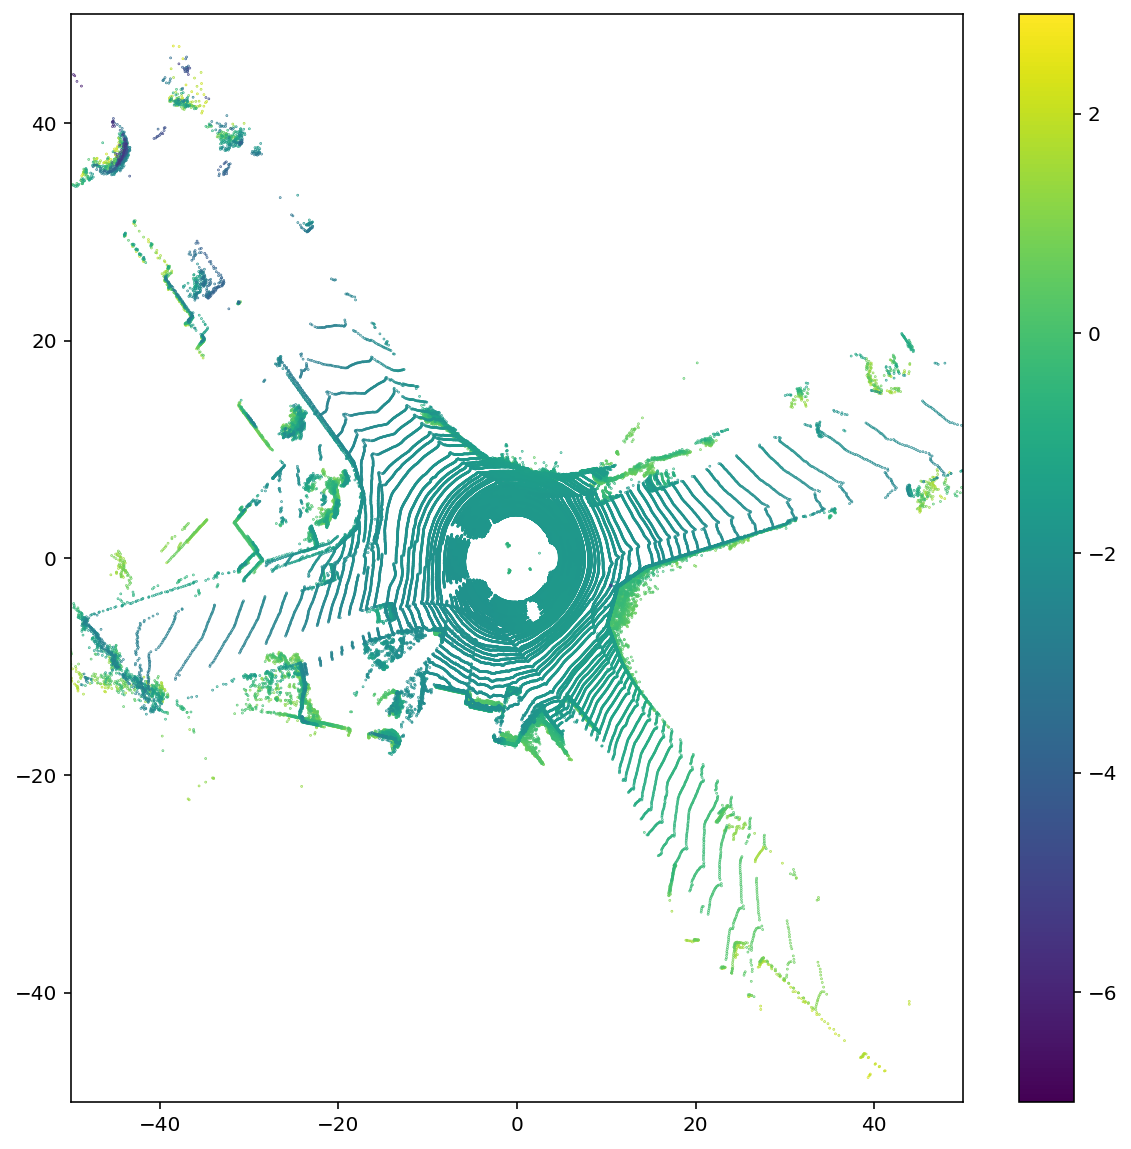

In [18]:
plt.figure(figsize=(10, 10))
plt.scatter(lidar[:, 0], lidar[:, 1], c=lidar[:, 2],  s=0.1)
plt.colorbar()
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.show()

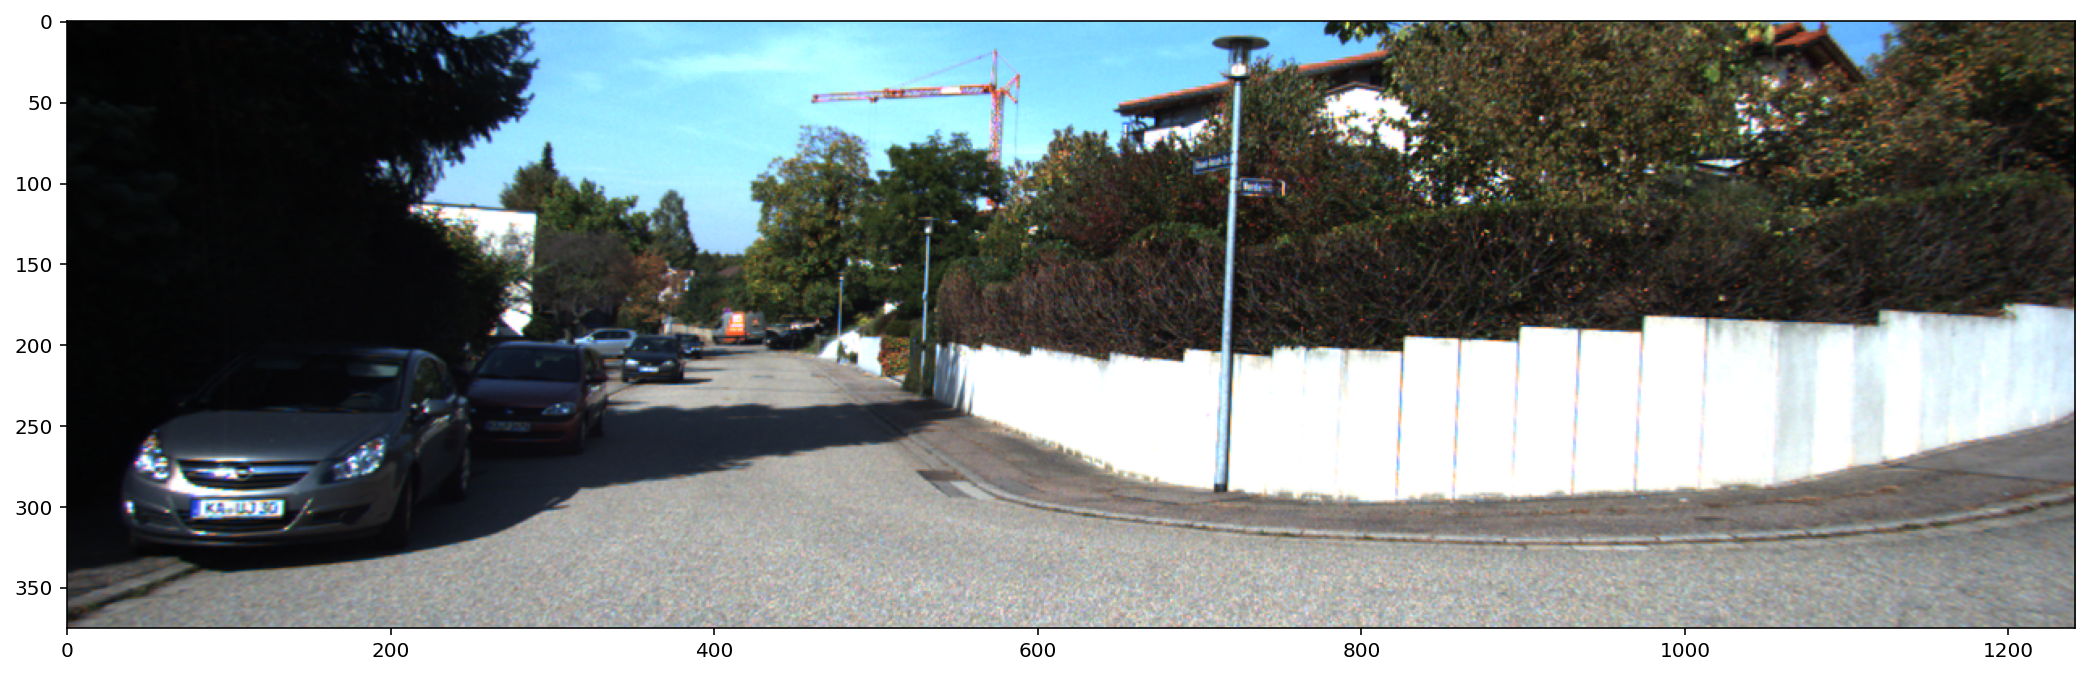

In [19]:
plt.figure(figsize=(18, 18))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
scene = pipeline_detector.predict(lidar, image, calibration)
scene.detections[0]

Detection(xyz=array([-5.82458799,  1.80281971,  9.47471036]), angle=1.277115493108266, lwh=array([3.76736293, 1.58808599, 1.5578036 ]), confidence=1.0)

Для работы с геометрией будем использовать библиотеку [shapely](https://shapely.readthedocs.io/en/stable/manual.html)

In [21]:
from shapely.geometry import Polygon
from shapely.affinity import rotate

In [22]:
def label_to_detection(label):
    return Detection(label.t, label.ry, np.array((label.l, label.w, label.h)), 1.)

def get_polygon_coords(x, y, l, w, angle):
    polygon = rotate(Polygon([[-w/2, -l/2], [-w/2, l/2], [w/2, l/2], [w/2, -l/2]]), -angle, use_radians=True)
    coords = np.array(polygon.exterior.coords)
    coords[:, 0] += x
    coords[:, 1] += y
    return Polygon([coords[0], coords[1], coords[2], coords[3]])

def get_boxes_coords(detections, calibration):
    boxes = []
    for detection in detections:
        x, y, _ = calibration.project_ref_to_velo(np.expand_dims(detection.xyz, 0))[0]
        box_coords = get_polygon_coords(x, y, *detection.lwh[:2], detection.angle)
        if box_coords.centroid.x ** 2 + box_coords.centroid.y ** 2 <= MAX_DISTANCE_TO_CENTER**2:
            boxes.append(box_coords)
    return boxes

In [23]:
label_boxes = get_boxes_coords(list(map(label_to_detection, labels)), calibration)

pred_boxes = get_boxes_coords(scene.detections, calibration)

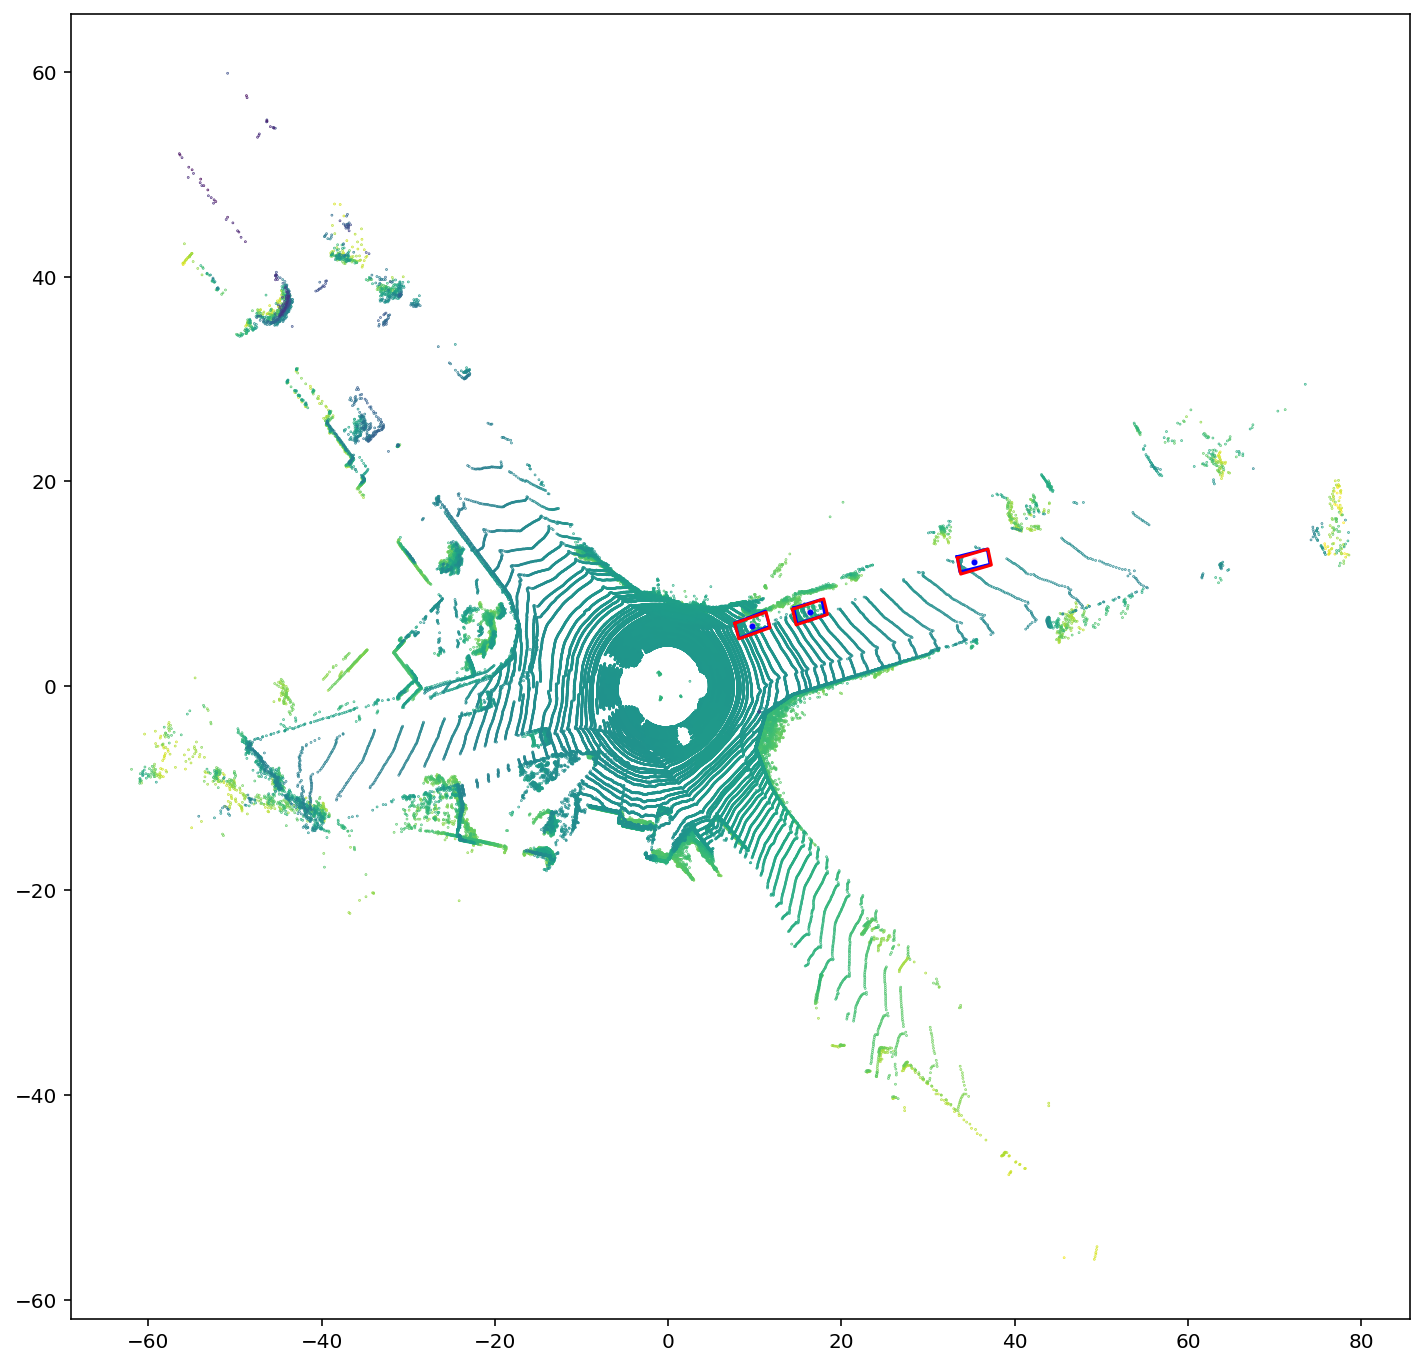

In [24]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(lidar[:, 0], lidar[:, 1], c=lidar[:, 2],  s=0.1)

for box in label_boxes:
    coords = np.array(box.exterior.coords)
    ax.plot(coords[:, 0], coords[:, 1], c='blue')
    ax.scatter([box.centroid.x], [box.centroid.y], c='pink', s=4)

for box in pred_boxes:
    coords = np.array(box.exterior.coords)
    ax.plot(coords[:, 0], coords[:, 1], c='red')
    ax.scatter([box.centroid.x], [box.centroid.y], c='blue', s=4)

plt.show()

# Оценивание

### Что сделано
К сожалению нельзя напрямую импортировать код из [`eval_det.py`](https://github.com/charlesq34/frustum-pointnets/blob/889c277144a33818ddf73c4665753975f9397fc4/sunrgbd/sunrgbd_detection/eval_det.py), так как там в нескольких местах используется `print` из второго питона.

Поэтому просто скопируем нужные функции (`voc_ap`, `eval_det_cls`) и создадим локально файлик

In [25]:
from eval_det import eval_det_cls

In [26]:
preds_sample = {sample_id: [(pred_box, detection.confidence) for pred_box, detection in zip(pred_boxes, scene.detections)]}
labels_sample = {sample_id: label_boxes}
rec, prec, ap = eval_det_cls(preds_sample, labels_sample, ovthresh=IOU_THRESHOLD)
ap 

0
NPOS:  3


1.0

In [28]:
from tqdm.autonotebook import trange

In [29]:
predictions = {}
gt_labels = {}

for sample_id in trange(1000):
    image = kitti_dataset.get_image(sample_id)
    lidar = kitti_dataset.get_lidar(sample_id)
    calibration = kitti_dataset.get_calibration(sample_id)
    labels = kitti_dataset.get_label_objects(sample_id)
    labels = [label for label in labels if label.type in KITTI_CAR_CLASSES]
    label_boxes = get_boxes_coords(list(map(label_to_detection, labels)),
                                   calibration)

    gt_labels[sample_id] = label_boxes

    scene = pipeline_detector.predict(lidar, image, calibration)
    pred_boxes = get_boxes_coords(scene.detections, calibration)
    predictions[sample_id] = [
        (pred_box, detection.confidence)
        for pred_box, detection in zip(pred_boxes, scene.detections)
    ]

Y:\hse\sdc\02\frustum_pointnets_test.py:115: RuntimeWarning: invalid value encountered in true_divide
  mask_mean_prob = mask_mean_prob / np.sum(batch_seg_mask, 1)  # B,


In [30]:
rec, prec, ap = eval_det_cls(predictions, gt_labels, ovthresh=IOU_THRESHOLD)
ap

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
NPOS:  2998


0.5191538172715386